## GRADE PREDICTION MODEL (Model de predicció de Nota Acadèmica)

### Autors
| **Name**              | **NIU**   |
|-----------------------|-----------|
| Albert Vacas Martínez   | 1665473   |


### Objectiu

Aquest projecte té l'objectiu de crear un model d'aprenentatge automàtic (*Machine Learning*) per predir la nota final d'un estudiant basant-se en diverses característiques. Aquest projecte es basa en el conjunt de dades **Student Grade Prediction** de Kaggle.

### Base de Dades

Per accedir a la Base de Dades: https://www.kaggle.com/datasets/dipam7/student-grade-prediction 

## Llibreries 

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from category_encoders import TargetEncoder
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import warnings
warnings.simplefilter(action='ignore')

Primer de tot, revisem l'estructura del nostre dataset i analitzem les dades.


In [31]:
df = pd.read_csv('dataset/student-mat.csv', engine='python', on_bad_lines='skip')

print("Primeres files del dataset:")
display(df.head())

print("\nInformació de les columnes:")
print(df.info())


Primeres files del dataset:


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10



Informació de les columnes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-n

In [32]:
df.info()

print(f"La base de dades té {df.shape[0]} files i {df.shape[1]} columnes.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

In [33]:
# Comprovació ràpida de valors nuls
print("\nValors nuls per columna:")
print(df.isna().sum()[df.isna().sum() > 0])

# Eliminar espais en blanc de les columnes de tipus 'object'
for col in df.select_dtypes(include='object').columns:
    df[col] = df[col].str.strip()

# Comprovació de Missing Values
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]

if missing_values.empty:
    print("No s'han trobat valors nuls (NaN) al dataset.")
else:
    print("Valors nuls trobats:")
    print(missing_values)


Valors nuls per columna:
Series([], dtype: int64)
No s'han trobat valors nuls (NaN) al dataset.


Podem observar que les dades del dataset no tenen valors nulls ni missing values, tampoc hem trobat columnes amb valors extranys o formats incorrectes. Aixó indica que les dades estan netes i podem preseguir al preprocessament de les dades. 

## Preprocessing 

Primer de tot, convertim les dades categoriques a numeriques ja que els models de regressió requereixen que les variables d'entrada siguin numeriques ja que basen el seu funcionament en operacions matemàtiques com sumes, productes i càlculs de gradients. 

Una primera aproximació podria ser assignar un número a cada categoria (per exemple, father = 0, mother = 1, other = 2). Tot i que aquesta estratègia és senzilla, no és adequada per a models de regressió lineal. Aquesta codificació introdueix un ordre artificial entre les categories, fet que porta que el model aprengui relacions que no existeixen en el món real, la qual cosa degrada la interpretabilitat i la qualitat de les prediccions.

Per evitar aquest problema, les variables categòriques nominals s’han codificat mitjançant One-Hot Encoding. Aquest mètode consisteix a crear una columna binària (0 o 1) per a cada categoria possible d’una variable.

Algunes variables categòriques del dataset només tenen dos valors possibles (yes / no). En aquests casos, la codificació directa a valors binaris (yes = 1, no = 0). En canvi, aquelles columnes com per exemple Mjob que defineix el treball del pare de l'estudiant (at_home, services, other, health...) apliquem One-Hot Encoding per evitar errors i que el model pugui interpretar les dades. 

Per garantir la reproductibilitat de l’experiment i la traçabilitat de les transformacions, totes les decisions de codificació s’han documentat i guardat en un fitxer JSON. Aquest fitxer conté:
- El mapeig de les variables binàries (yes/no)
- Les categories originals utilitzades en el One-Hot Encoding

In [ ]:

y = df['G3']


X = df.drop(columns=['G3'])

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

binary_cols = [
    'schoolsup','famsup','paid','activities',
    'nursery','higher','internet','romantic'
]

nominal_cols = [
    'school','sex','address','famsize','Pstatus',
    'Mjob','Fjob','reason','guardian'
]

binary_map = {'no': 0, 'yes': 1}

X_train_enc = X_train.copy()
X_test_enc = X_test.copy()

onehot_map = {}

for col in nominal_cols:
    categories = sorted(X_train[col].unique())
    onehot_map[col] = categories

    for cat in categories[1:]:
        new_col = f"{col}_{cat}"
        X_train_enc[new_col] = (X_train[col] == cat).astype(int)
        X_test_enc[new_col] = (X_test[col] == cat).astype(int)

    # Eliminar columna original
    X_train_enc.drop(columns=col, inplace=True)
    X_test_enc.drop(columns=col, inplace=True)

for col in binary_cols:
    X_train_enc[col] = X_train[col].map(binary_map)
    X_test_enc[col] = X_test[col].map(binary_map)

print("Features després de l'encoding:")
print(f"Nombre de features finals: {X_train_enc.shape[1]}")
display(X_train_enc.head())



Features després de l'encoding:
Nombre de features finals: 41


,age,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,...,Mjob_teacher,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_home,reason_other,reason_reputation,guardian_mother,guardian_other
181,16,3,3,1,2,0,0,0,1,1,...,0,0,1,0,0,1,0,0,1,0
194,16,2,3,2,1,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
173,16,1,3,1,2,3,0,0,0,1,...,0,0,0,1,0,1,0,0,1,0
63,16,4,3,1,3,0,1,1,1,1,...,1,1,0,0,0,1,0,0,1,0
253,16,2,1,2,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0


In [ ]:
from sklearn.preprocessing import StandardScaler

numerical_cols_to_scale = [
    'age','Medu','Fedu','traveltime','studytime',
    'failures','famrel','freetime','goout',
    'Dalc','Walc','health','absences'
]

scaler = StandardScaler()

# Ajustem i transformem el Train Set
X_train_enc[numerical_cols_to_scale] = scaler.fit_transform(
    X_train_enc[numerical_cols_to_scale]
)

# Transformem el Test Set amb el fit del Train Set
X_test_enc[numerical_cols_to_scale] = scaler.transform(
    X_test_enc[numerical_cols_to_scale]
)

# Amb Standard Scaler, els valors estaran centrats al voltant de 0
print("\nResultats de la Normalització")
display(X_train_enc.head())

X_test_enc.info()


Resultats de la Normalització


,age,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,activities,...,Mjob_teacher,Fjob_health,Fjob_other,Fjob_services,Fjob_teacher,reason_home,reason_other,reason_reputation,guardian_mother,guardian_other
181,-0.586396,0.246437,0.423207,-0.625779,-0.056853,-0.456744,0,0,1,1,...,0,0,1,0,0,1,0,0,1,0
194,-0.586396,-0.680636,0.423207,0.828236,-1.254553,-0.456744,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
173,-0.586396,-1.607709,0.423207,-0.625779,-0.056853,3.628097,0,0,0,1,...,0,0,0,1,0,1,0,0,1,0
63,-0.586396,1.173510,0.423207,-0.625779,1.140847,-0.456744,1,1,1,1,...,1,1,0,0,0,1,0,0,1,0
253,-0.586396,-0.680636,-1.434203,0.828236,-1.254553,-0.456744,0,0,0,1,...,0,0,1,0,0,0,0,0,1,0


<class 'pandas.core.frame.DataFrame'>
Index: 79 entries, 78 to 18
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                79 non-null     float64
 1   Medu               79 non-null     float64
 2   Fedu               79 non-null     float64
 3   traveltime         79 non-null     float64
 4   studytime          79 non-null     float64
 5   failures           79 non-null     float64
 6   schoolsup          79 non-null     int64  
 7   famsup             79 non-null     int64  
 8   paid               79 non-null     int64  
 9   activities         79 non-null     int64  
 10  nursery            79 non-null     int64  
 11  higher             79 non-null     int64  
 12  internet           79 non-null     int64  
 13  romantic           79 non-null     int64  
 14  famrel             79 non-null     float64
 15  freetime           79 non-null     float64
 16  goout              79 non-null  

Hem analitzat la correlació de les variables amb la nota final (`G3`).
- Inicialment, vam observar que les variables socioeconòmiques tenen correlacions baixes.
- Hem experimentat filtrant variables amb poca correlació (llindar 0.05) per intentar reduir el soroll del model.

In [ ]:
# Selecció de Característiques per Correlació 

X_train_filtered = X_train_enc.copy()
X_test_filtered = X_test_enc.copy()


df_train_corr = pd.concat([X_train_filtered, y_train], axis=1)

# Calculem la correlació 
correlations = df_train_corr.corr()["G3"]

llindar = 0.05

seleccionades = correlations[correlations.abs() > llindar].index.tolist()

if 'G3' in seleccionades:
    seleccionades.remove('G3')

print(f"Número de features originals: {X_train_enc.shape[1]}")
print(f"Número de features seleccionades (amb corr > {llindar}): {len(seleccionades)}")

if len(seleccionades) > 0:
    print("\nFeatures seleccionades:")
    print(seleccionades)

    X_train_filtered = X_train_filtered[seleccionades]
    X_test_filtered = X_test_filtered[seleccionades]
    
    # Comprovem els resultats
    print("\nPrimeres files de X_train_filtered:")
    display(X_train_filtered.head())
else:
    print("\nCap feature té una correlació absoluta superior a 0.2 amb G3.")


Número de features originals: 41
Número de features seleccionades (amb corr > 0.05): 27

Features seleccionades:
['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'paid', 'higher', 'internet', 'romantic', 'famrel', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'sex_M', 'address_U', 'famsize_LE3', 'Pstatus_T', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'reason_reputation', 'guardian_other']

Primeres files de X_train_filtered:


,age,Medu,Fedu,traveltime,studytime,failures,paid,higher,internet,romantic,...,G2,sex_M,address_U,famsize_LE3,Pstatus_T,Mjob_health,Mjob_other,Mjob_services,reason_reputation,guardian_other
181,-0.586396,0.246437,0.423207,-0.625779,-0.056853,-0.456744,1,1,1,1,...,13,1,1,0,1,0,0,1,0,0
194,-0.586396,-0.680636,0.423207,0.828236,-1.254553,-0.456744,0,1,1,0,...,14,1,1,0,1,0,1,0,0,0
173,-0.586396,-1.607709,0.423207,-0.625779,-0.056853,3.628097,0,1,1,1,...,7,0,1,0,1,0,0,0,0,0
63,-0.586396,1.173510,0.423207,-0.625779,1.140847,-0.456744,1,1,1,0,...,9,0,1,0,1,0,0,0,0,0
253,-0.586396,-0.680636,-1.434203,0.828236,-1.254553,-0.456744,0,1,0,0,...,9,1,0,0,1,0,1,0,0,0


## Sel·lecció de model

Utilitzem Optimització Bayesiana (`BayesSearchCV`) en lloc de GridSearch.
- Aquest mètode és més eficient ja que "aprèn" de les proves anteriors per trobar els millors hiperparàmetres.
- Avaluem 5 famílies de models: Linear Regression, Lasso, Ridge, SVR i Random Forest.
- Utilitzem Repeated K-Fold Cross Validation per assegurar que els resultats són robustos i no fruit de l'atzar.

In [37]:
pipe = Pipeline([
    ('model', LinearRegression()) 
])


# Definim els models i els rangs d'hiperparàmetres a provar
param_grid = [
    # Regressió Lineal 
    {'model': [LinearRegression()]},
    
    # Lasso 
    {
        'model': [Lasso(random_state=42)],
        # Cerca logarítmica d'Alpha entre 0.001 i 10
        'model__alpha': Real(0.001, 10, prior='log-uniform')
    },
    
    # Ridge 
    {
        'model': [Ridge(random_state=42)],
        'model__alpha': Real(0.001, 10, prior='log-uniform')
    },
    
    # Support Vector Regressor (SVR)
    {
        'model': [SVR()],
        'model__C': Real(0.1, 100, prior='log-uniform'),
        'model__gamma': Categorical(['scale', 'auto']),
        'model__kernel': Categorical(['linear', 'rbf'])
    },
    
    # Random Forest Regressor
    {
        'model': [RandomForestRegressor(random_state=42)],
        'model__n_estimators': Integer(50, 300),
        'model__max_depth': Integer(3, 20),
        'model__min_samples_split': Integer(2, 10)
    }
]


cv = RepeatedKFold(n_splits=5, n_repeats=2, random_state=42)

# Cerca Bayesiana
search = BayesSearchCV(
    estimator=pipe,
    search_spaces=param_grid,
    cv=cv,
    n_iter=30, 
    scoring='neg_mean_absolute_error', 
    random_state=42,
    n_jobs=-1, 
    verbose=0
)

print("Iniciant l'entrenament dels models i l'optimització d'hiperparàmetres...")

# Entrenem amb les dades train codificades i escalades
search.fit(X_train_filtered, y_train)

print("\nResultats de la Selecció:")
print(f"Millor Score (MAE negatiu): {search.best_score_:.4f}")
print(f"Millor Model i Paràmetres: {search.best_params_['model']}")

Iniciant l'entrenament dels models i l'optimització d'hiperparàmetres...

Resultats de la Selecció:
Millor Score (MAE negatiu): -0.9759
Millor Model i Paràmetres: RandomForestRegressor(random_state=42)


## Model evaluation

Resultats Finals al Test Set (Model: RandomForestRegressor) ---
MAE (Error Absolut Mitjà): 1.0942 punts
RMSE (Error Quadràtic Mitjà): 1.8780 punts
R² (Coeficient de Determinació): 0.8280


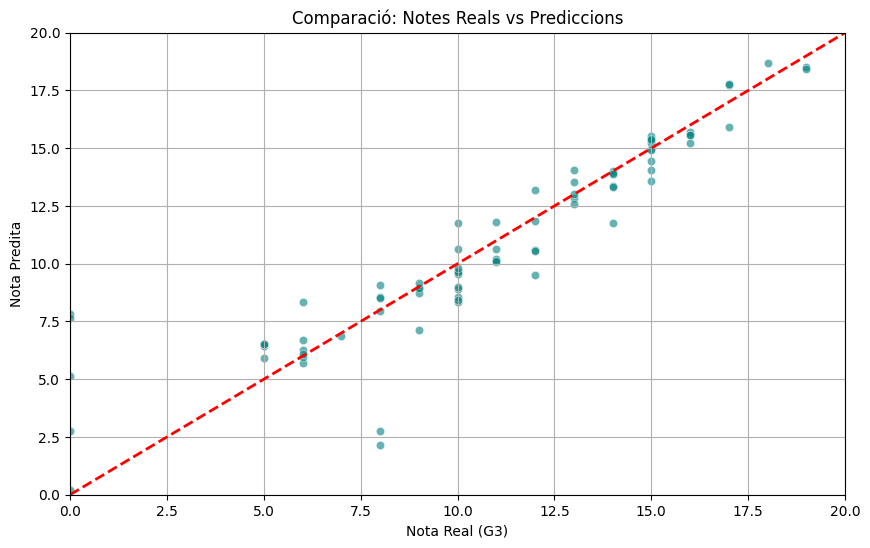

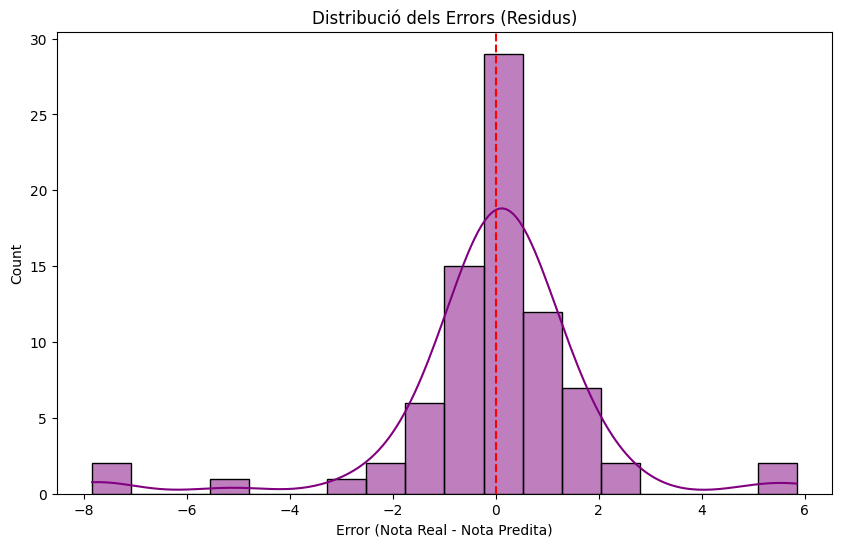

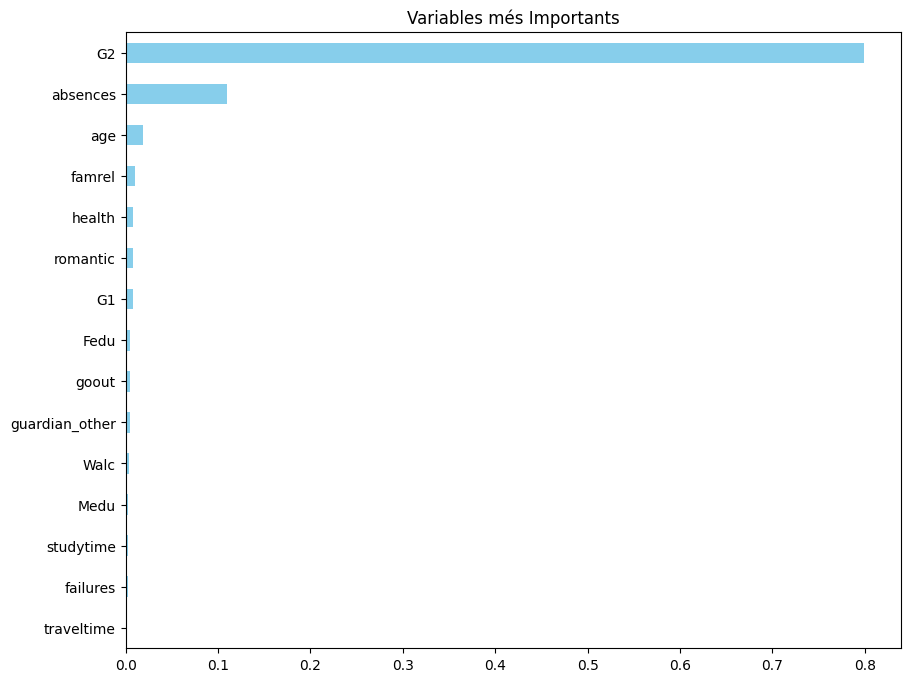

In [38]:
# Recuperem el millor model
best_model = search.best_estimator_

# Fem prediccions 
y_pred = best_model.predict(X_test_filtered)

# Assegurem que les prediccions no passen de 20 ni baixen de 0
y_pred = np.clip(y_pred, 0, 20) 

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Resultats Finals al Test Set (Model: {search.best_params_['model'].__class__.__name__}) ---")
print(f"MAE (Error Absolut Mitjà): {mae:.4f} punts")
print(f"RMSE (Error Quadràtic Mitjà): {rmse:.4f} punts")
print(f"R² (Coeficient de Determinació): {r2:.4f}")

# Gràfic Predicció vs Realitat
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, color='teal', alpha=0.6)

plt.plot([0, 20], [0, 20], 'r--', lw=2)
plt.xlabel('Nota Real (G3)')
plt.ylabel('Nota Predita')
plt.title('Comparació: Notes Reals vs Prediccions')
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.grid(True)
plt.show()

# Gràfic Distribució dels Errors (Residus)
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='purple')
plt.axvline(x=0, color='red', linestyle='--')
plt.title('Distribució dels Errors (Residus)')
plt.xlabel('Error (Nota Real - Nota Predita)')
plt.show()


# Gràfic Importància de les Variables 
if isinstance(search.best_params_['model'], RandomForestRegressor):
    rf_model = best_model.named_steps['model']
    
    importances = pd.Series(rf_model.feature_importances_, index=X_train_filtered.columns)
    
    plt.figure(figsize=(10, 8))
    
    # Mostrem les 15 variables més importants
    importances.sort_values(ascending=False).head(15).plot(kind='barh', color='skyblue')
    plt.title('Variables més Importants')
    plt.gca().invert_yaxis()
    plt.show()



El procés d'avaluació final al conjunt de dades de Test ha confirmat la robustesa i la capacitat predictiva del model RandomForestRegressor. Amb un Coeficient de Determinació ($R^2$) de 0.8280, el model és capaç d'explicar el 82.8% de la variància total de la nota final (G3). Aquest alt rendiment es reflecteix directament en la visualització de les dades.

En el grafic de Predicció vs. Realitat es pot observar una concentració molt estreta i lineal dels punts al voltant de la línia de referència de 45 graus. Això indica que les prediccions del model (y_pred) són extremadament properes a les notes reals (y_test), amb una desviació mitjana (MAE) de només 1.09 punts.

En el grafic de Residus la distribució dels errors mostra una concentració gairebé perfecta al voltant de zero, amb una forma de campana. Això confirma que el model no té cap biaix sistemàtic i que els errors són mínims i aleatoris.

Per ultim, l'ultim grafic de les millors variables per predir G3 ens indica que les variables mes important son G2 i absences. Aixo ens permet concluir que el model és una eina altament fiable, robusta i precisa per a la predicció del rendiment acadèmic. La seva alta eficàcia es basa en la continuïtat del rendiment previ (G2) complementada per factors de disciplina i assistència (absences).

La qualitat de les mètriques en el conjunt de Test confirma que el model generalitza bé el coneixement après. El fet que els errors siguin baixos i la distribució sigui centrada i estreta demostra que el model no ha memoritzat només les dades d'entrenament, sinó que ha après les regles de relació entre les variables.

